In [1]:
import csv
import pickle
import re
import os 

import gensim
from gensim import corpora

In [2]:
def data_import(dir_path, fname):
    # Read csv file as list of lists. 
    # Then clean the list of lists 

    with open(dir_path + fname, newline = '') as f:
            reader = csv.reader(f)
            data = list(reader)[1:]
            data = list(map(str, data))
            
    data = [re.sub(r'\b[A-Z]+(?:\s+[A-Z]+)*\b', '', ls) for ls in data] # remove words that are all upper case - so names 
    data = [re.sub(r'\\\\n|\\\\t|\'s', '', ls) for ls in data] # remove line breaks, tab breaks, and possessive "s"
    data = [re.sub(r'[^\w\s]|_', '', ls) for ls in data] # remove punctuation and underscore
    data = [re.sub(r'\d{1, 3}', '', ls) for ls in data] # remove digits that are a minimum of 1 and a maximum of 3
    data = [re.sub(r'\w*\d\w*', '', ls) for ls in data] # remove character strings that contain a digit
        
    data = [word.lower() for word in data]
    data = [ls.split() for ls in data]

    return data

In [3]:
working_dir = '/username/faha/'
fname = 'congress_2001.csv'

In [4]:
data = data_import(working_dir, fname)

data[:5]

[['the', 'majority', 'leader'],
 ['senator'],
 ['is', 'recognized'],
 ['mr', 'president'],
 ['on', 'behalf', 'of', 'the', 'entire', 'senate']]

In [5]:
dictionary = corpora.Dictionary(data)

corpus = [dictionary.doc2bow(text) for text in data]

corpus[:2]

[[(0, 1), (1, 1), (2, 1)], [(3, 1)]]

In [6]:
%%time

lda_model = gensim.models.LdaMulticore(corpus, num_topics = 100, id2word = dictionary, workers = 24, passes = 15)

CPU times: user 29min 44s, sys: 26min 13s, total: 55min 58s
Wall time: 52min 55s


### Saving Our Model

Topic modeling is a computationally intensive process that can take quite some time to complete. Large data sets can take hours to process! We can save our models to our computer so that we don't have to recreate a model (and go through such a long waiting period) each time we want to analyze our data.

The following code creates a folder named `lda_topic_models` in our working directory if the folder does not already exist. 

In [11]:
working_folder = working_dir + 'lda_topic_models/'

if not os.path.exists(working_folder):
    os.mkdir(working_folder)

Now we can save three important files to `lda_topic_models`: `corpus.pkl`, `dictionary.gensim`, `model.gensim`. 

`corpus.pkl` and `dictionary.gensim` both contain data we produced for topic modeling, whereas `lda_model.gensim` contains the topic model itself.

In [13]:
pickle.dump(corpus, open(working_folder + 'corpus.pkl', 'wb'))
dictionary.save(working_folder + 'dictionary.gensim')
lda_model.save(working_folder + 'lda_model.gensim')

### Loading Our Model

We can load our saved data and continue working with it. The following code shows how to load each of our component parts. We can use `corpus` and `dictionary` if we want to create a new model using our existing data, or we can use `lda_model` to work with our already generated model. 

In [15]:
corpus = pickle.load(open(working_folder +  'corpus.pkl', 'rb'))
dictionary = gensim.corpora.Dictionary.load(working_folder + 'dictionary.gensim')
lda_model = gensim.models.ldamodel.LdaModel.load(working_folder + 'lda_model.gensim')

### Exploring Topics

We can explore our topics like so, but it's more informative to visualize them.

In [16]:
lda_model.show_topics(formatted = False, num_topics = 5)

[(66,
  [('to', 0.09295215),
   ('the', 0.063810945),
   ('that', 0.057987615),
   ('clear', 0.048571523),
   ('is', 0.04632432),
   ('it', 0.03797598),
   ('agreed', 0.03198486),
   ('was', 0.029042428),
   ('be', 0.021456424),
   ('and', 0.021043593)]),
 (56,
  [('the', 0.083223924),
   ('of', 0.051834144),
   ('in', 0.047514383),
   ('and', 0.028744793),
   ('south', 0.024663886),
   ('central', 0.01972065),
   ('occurred', 0.0190347),
   ('commercial', 0.0176652),
   ('sugar', 0.014889359),
   ('thomas', 0.014559975)]),
 (46,
  [('security', 0.08556709),
   ('the', 0.057400648),
   ('and', 0.03306812),
   ('social', 0.028789312),
   ('fund', 0.026713239),
   ('understand', 0.026152998),
   ('is', 0.025129529),
   ('leader', 0.025059095),
   ('majority', 0.024255427),
   ('medicare', 0.021417236)]),
 (75,
  [('the', 0.08498082),
   ('of', 0.05744072),
   ('defense', 0.051716637),
   ('provisions', 0.04341322),
   ('and', 0.031126322),
   ('in', 0.023916315),
   ('month', 0.021119414

### Visualizing Our Topics

The following code first transforms our data into a new structure that is conducive to visualizing. It then visualizes the first 26 topics in our topic model. You can show more topics by changing `range(0,3)` (the first line of the for loop to our visualization code) to another number (e.g. `range(0,10)`)

In [17]:
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt

In [18]:
topics = lda_model.show_topics(formatted = False, num_topics = 100)
            
data_flat = [w for w_list in data for w in w_list]
counter = Counter(data_flat)
            
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
df.to_csv(working_dir + 'LDA_100_topic_model' + '.csv')

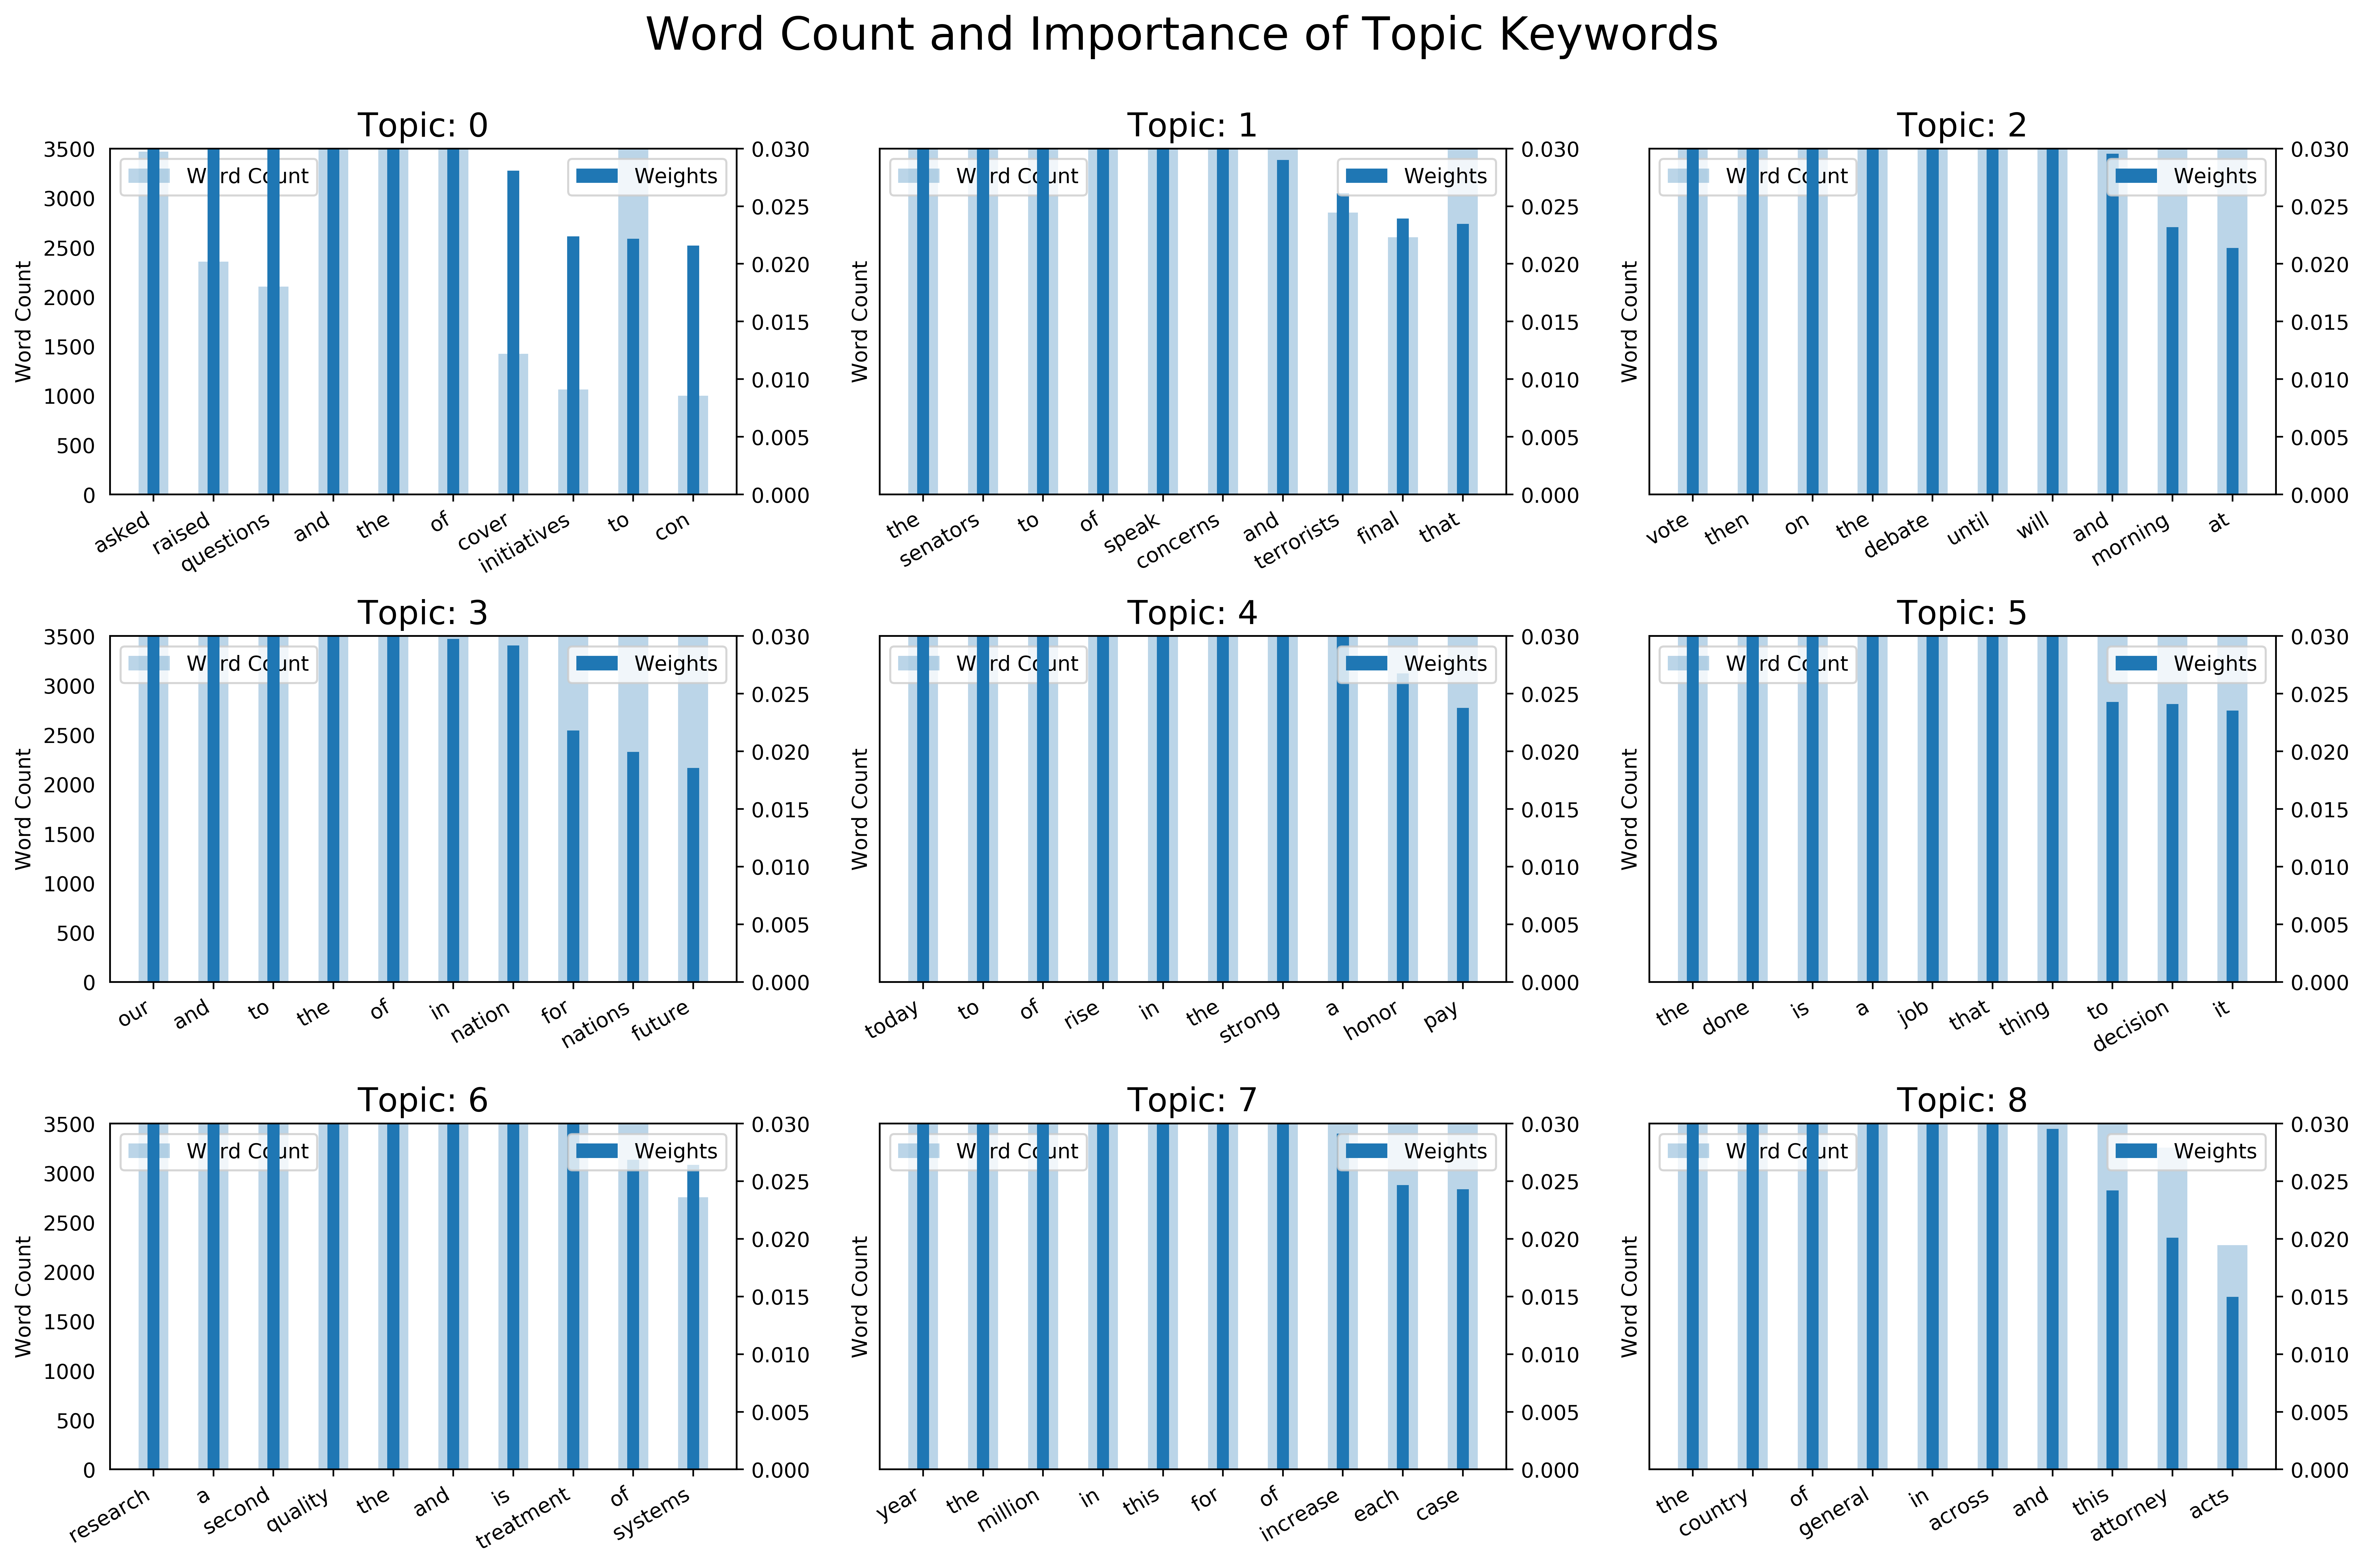

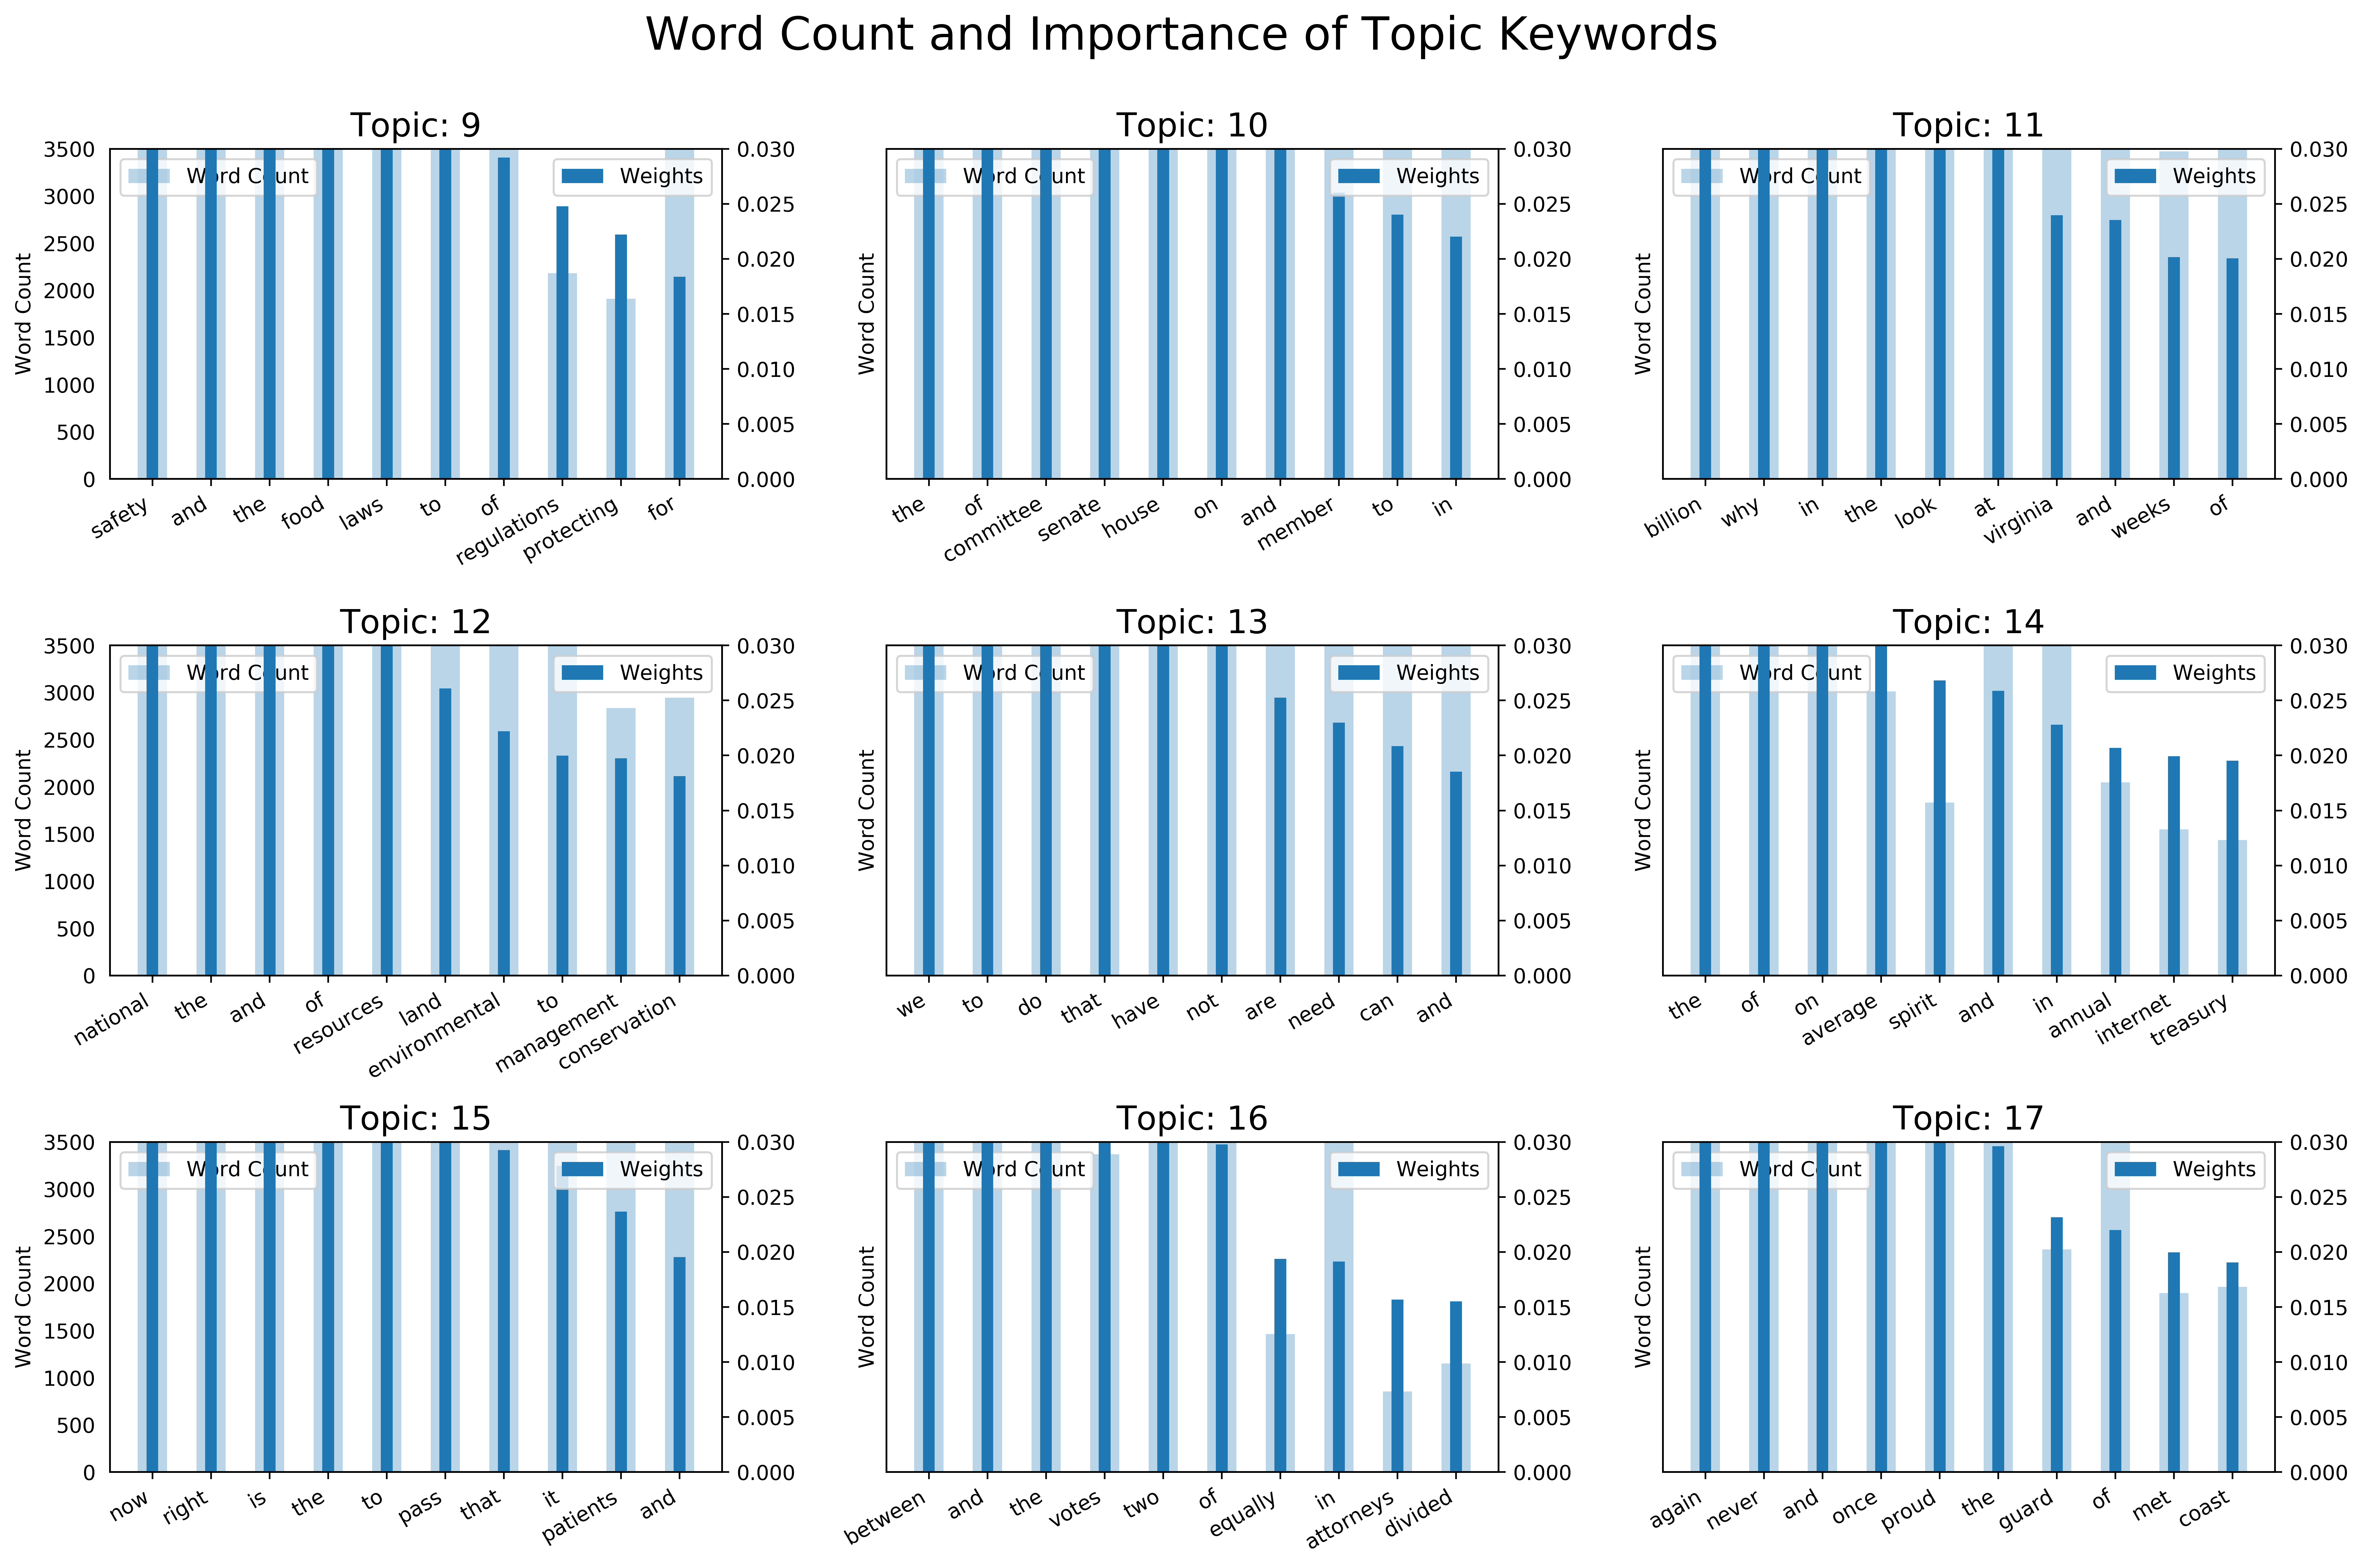

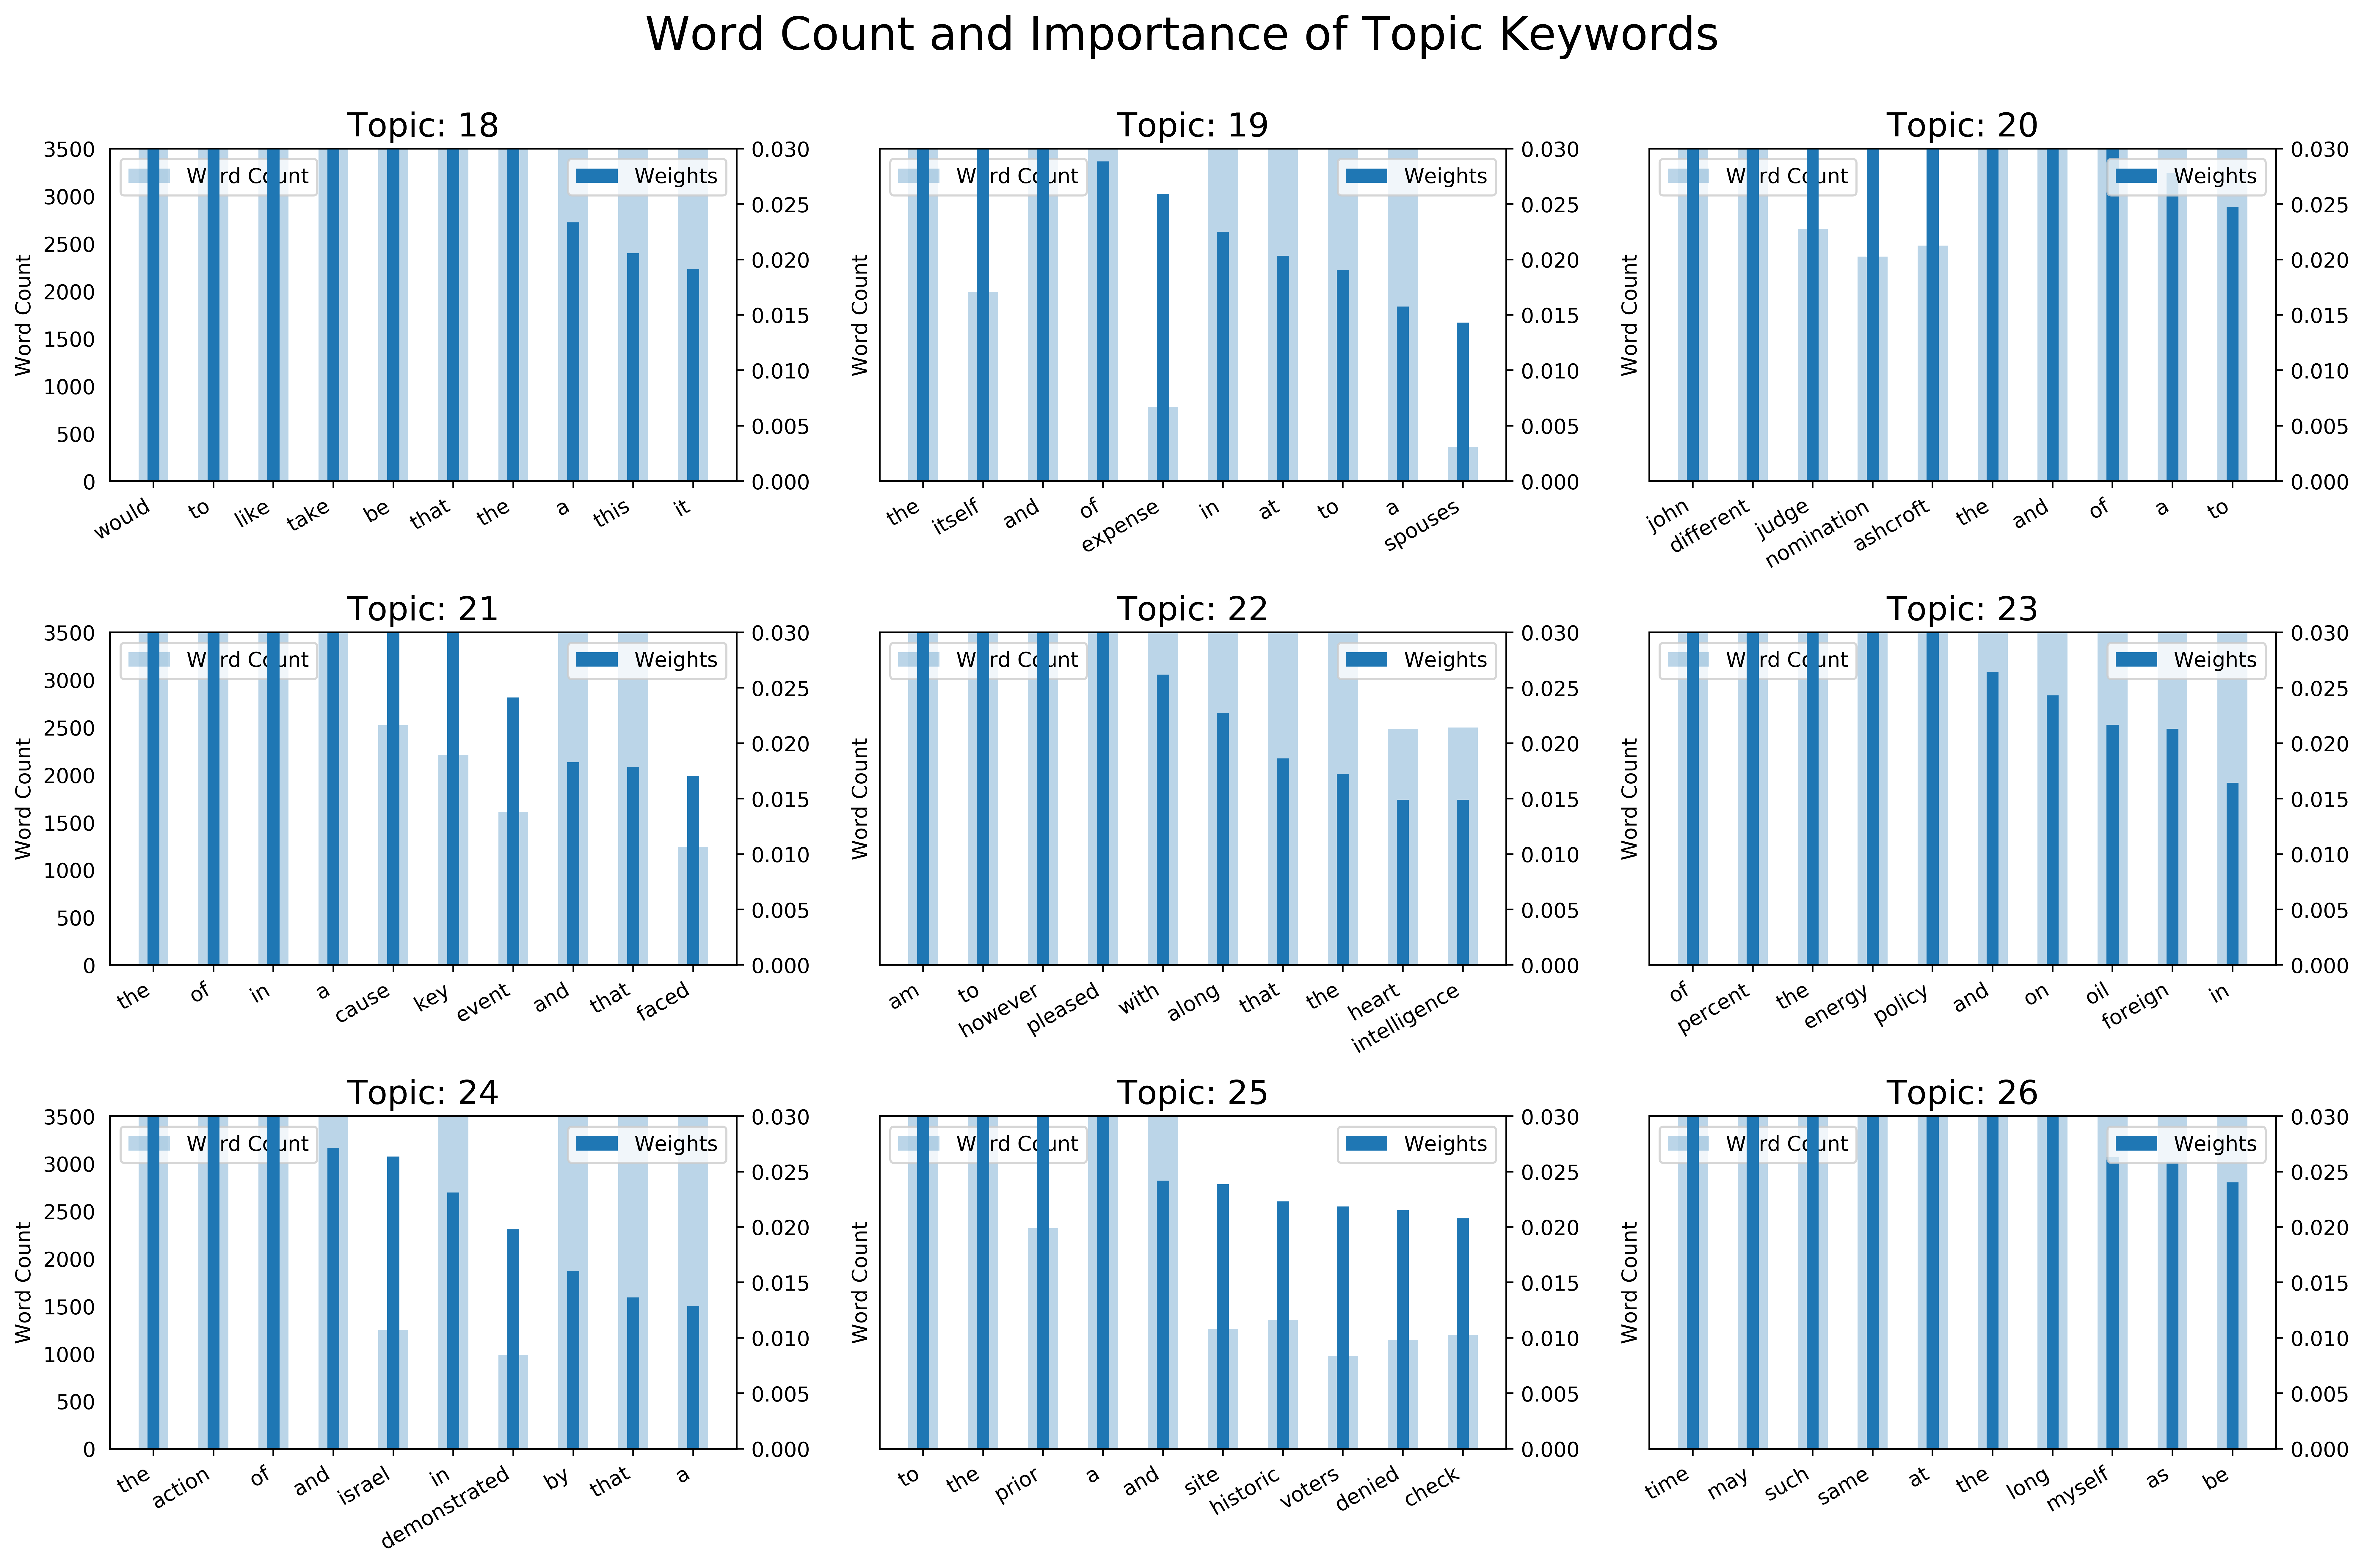

In [19]:
start = -9
stop = 0

for t in range(0,3): # change to however many visualizations you wish to see 
    start = start + 9
    stop = stop + 8

    fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=500)

    for i, ax in enumerate(axes.flatten()):
        i = i + start 

        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :],  width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :],  width=0.2, label='Weights')
        ax.set_ylabel('Word Count')
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), fontsize=16) 
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()